In [3]:
from datetime import time
from matplotlib import markers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from glob import glob
from seaborn import palettes
from seaborn.categorical import swarmplot
from tqdm import tqdm
import json
from scipy.signal import detrend
from scipy.ndimage import gaussian_filter1d
import os
import re
import math
import matplotlib.ticker as tck
import glob
import argparse
import statsmodels.api as sm


In [16]:
paths = glob.glob(os.path.join("E:/Turku_collab/lunagel_50s/remodelling", "**","summary_ID_level.csv"),recursive=True)
print(*paths, sep='\n')


E:/Turku_collab/lunagel_50s/remodelling\24_120\120\0_241111\241111_10um_3layer_50s_MDAMB231\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\120\0_241111\241111_10um_3layer_50s_control\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\120\1_241125\241125_10um_3layers_50s_control\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\120\1_241125\241125_10um_3layers_50s_MDAMB231\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\24\0_241107\241107_10um_3layer_50s_control\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\24\0_241107\241107_10um_3layer_50s_MDAMB231\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\24\1_241121\241121_10um_3layer_50s_MDAMB231\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\24\1_241121\241121_10um_3layer_50s_control\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodellin

In [17]:
df_list = []
data =[]
for i in paths:
    data = pd.read_csv(i)     
    parts = i.split('\\') 
    data['incubation_set'] = parts[1]
    data['incubation'] = parts[2]
    data['experiment'] = parts[3].split('_')[0]
#    data['date'] = parts[3].split('_')[1]
    data['sample'] = parts[4].split('_')[-1]
    
    max_location = data['location'].unique().max()
    
    # condition = (data['incubation_set'] == "48_144") & (data['experiment'] == 1)
    # if len(data.loc[condition]) > 0:
    #     data = data[~((data['location'] == 1))]  # This removes rows with location == 1
    #     data = data[~((data['location'] == 2))]  
    #     # Shift the location column by 1 lower for the remaining data
    #     data.loc[condition, 'location'] -= 2

    for j, location in enumerate(data['location'].unique()):
        # Use .loc to properly assign values to the dataframe
        data.loc[data['location'] == location, 'gradient'] = data['y'] + location*665.6
        data.loc[data['location'] == location, 'gradient_inverse'] = data['y'] + (max_location-location)*665.6
    
    # data = data[~((data['gradient'] < 500))]  
    # data = data[~((data['gradient_inverse'] < 500))]  
    
    df_list.append(data)

    # print(i)
    # print( parts[1],parts[2],parts[3].split('_')[0],parts[4].split('_')[-1])


df = pd.concat(df_list, ignore_index=True)



In [18]:
saving_path = 'C:/Users/srboval1/OneDrive - Aalto University/Collab/Ivaska_collab/data'
df.to_csv(saving_path+'/gradients.csv')  


In [5]:
saving_path = 'C:/Users/srboval1/OneDrive - Aalto University/Collab/Ivaska_collab/data'
download = pd.read_csv(saving_path +'/gradients.csv', index_col=None)
print(download.columns)
download['day'] = download['day'].astype(str)



Index(['Unnamed: 0.1', 'Unnamed: 0', 'day', 'sample', 'holder', 'location',
       'track_id', 'reference_id', 'distance(um)', 'Cov_Sum', 'a_(um)',
       'phi_(rad)', 'c', 'd', 'G_abs', 'radius_(m)', 'rmse', 'inv.rmse',
       'shift_(s)', 'a_error', 'phi_error', 'c_error', 'd_error', 'x', 'y',
       'repeat', 'phi_(deg)', 'tan_phi', 'incubation_set', 'incubation',
       'experiment', 'gradient', 'gradient_inverse', 'gradient_direction'],
      dtype='object')


In [91]:
download['experiment']

0      0
1      0
2      0
3      0
4      0
      ..
862    1
863    1
864    1
865    1
866    1
Name: experiment, Length: 867, dtype: int64

Assigning direction of gradient at which it was measured (loc1-->locx)

In [6]:
download['gradient_direction'] = np.where(
    ((download['sample'] == "MDAMB231") & (download['day'] == "241107")) | 
    (download['day'].isin(["241122","241125","241121","241126"])),
    "stiff_to_soft",
    "soft_to_stiff"
)


In [7]:
print(download['gradient_direction'].unique())
print(download['day'].unique())
print(download['sample'].unique())


['soft_to_stiff' 'stiff_to_soft']
['241111' '241125' '241107' '241121' '241108' '241122' '241112' '241126']
['MDAMB231' 'control']


In [8]:
download.to_csv(saving_path+'/gradients.csv')  

## GLS model

In [9]:
alpha = 0.05
def GLS_g(data,ax, color):
    x= data['gradient'].values.reshape(-1,1)
    y= np.log(data['G_abs'])

    # Fit GLS model
    x_const = sm.add_constant(x)  # adds a column of ones to independent variable - allows to estimate the intercept
    
    #Fitting the model to the data
    modelGLS = sm.GLS(y,x_const)

    #Model parameters
    resultsGSL = modelGLS.fit()
    #print(resultsGSL.summary())

    #CI
    confidence_intervals = resultsGSL.conf_int(alpha=0.05)

    # Generate predictions for the original data
    x_predictedGLS = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)  # Model x-space
    x_predictedGLS_with_const = sm.add_constant(x_predictedGLS)  # Add constant for predictions

    # Prediction of y based on the model
    y_predictedGLS_log = resultsGSL.predict(x_predictedGLS_with_const)  # Get predictions
    y_predictedGLS = np.exp(y_predictedGLS_log)  # Transform back from log scale

    predictions = resultsGSL.get_prediction(x_predictedGLS_with_const)
    pred_summary = predictions.summary_frame(alpha=alpha)
    y_lower_CI = np.exp(pred_summary['obs_ci_lower'])
    y_upper_CI = np.exp(pred_summary['obs_ci_upper'])

    # CI for the predictions
    predictions = resultsGSL.get_prediction(x_predictedGLS_with_const)
    pred_summary = predictions.summary_frame(alpha=alpha)  #

    ax.scatter(data['f'],data['G_abs'],s=4, c=color) #measured from soft to stiff
    #ax.plot(x_predictedGLS, y_predictedGLS, color=color, label='Fitted Line')  # Fitted line
    #ax.fill_between(x_predictedGLS.flatten(), y_lower_CI, y_upper_CI,
                         #color=color, alpha=0.1, label='Confidence Interval')
    ax.set_ylim (0,100) 
    ax.set_xlim (0,5000)  

    #print(resultsGSL.bse)


In [10]:
from scipy.optimize import curve_fit

def fitting(ax,x_data, y_data,color_type,marker_type):
    
    def logistic_func(x, L, k, x0):
        return L / (1 + np.exp(-k * (x - x0)))
    
    k_guess = 0.1  # initial slope estimate, a smaller value usually works
    L_guess = np.max(y_data) 
    k_guess = 0.1
    x0_guess = 2500
    params, _ = curve_fit(logistic_func, x_data, y_data,p0=[L_guess, k_guess, x0_guess], maxfev=10000)
    L, k, x0 = params

    # Display the fitted parameters
    print(f'Fitted parameters: L = {L:.3f}, k = {k:.3f}, x0 = {x0:.3f}')

    # Plot the data and the fitted logistic curve
    ax.scatter(x_data, y_data, label='Data', s=35,c=color_type, marker=marker_type)
    #ax.plot(x_data, logistic_func(x_data, *params), label=f'Logistic fit: L={L:.3f}, k={k:.3f}, x0={x0:.3f}', color=color_type)



Plotting G

Kernel Ridge Regression

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler

def fitting_kernel(x, y, ax, color_type, marker_type,alpha):
    x_reshaped = x.values.reshape(-1, 1)  #     # Reshape x to a 2D array (required for scikit-learn models), converts x into a 2D array with shape (n_samples, 1)
    y_reshaped = y.values 
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_reshaped)  # Standardize x data
    # Note: We don't scale y, since it's already a scalar
    
    # Initialize Kernel Ridge Regression model
    # similarity between two points in higher-dimensional space = this is done using a kernel function, here Radial Basis Function (RBF) kernel
    # ALPHA = regularization factor
    krr = KernelRidge(kernel='rbf', alpha=alpha)  # A larger --> more regularization; model prioritizes simpler solutions fitting general trend and not capture smaller details
    # Fit the model with the given data
    krr.fit(x_scaled, y_reshaped)

    # Grid of x values for the kernel fit (scaled)
    x_fit = np.linspace(np.min(x_scaled), np.max(x_scaled), 1000)[:, np.newaxis]  # Fine grid for prediction
    y_fit = krr.predict(x_fit)  # Predict the y values for the fine grid

    # Rescale x_fit back to original scale for plotting
    x_fit_original = scaler.inverse_transform(x_fit)  # Rescale the x values back

    # Plot the original data as a scatter plot
    ax.scatter(x_reshaped, y_reshaped, label='Original Data', color=color_type, marker=marker_type)

    # Plot the kernel fit (the kernel regression curve)
    ax.plot(x_fit_original, y_fit,color=color_type, label='Kernel Fit', linewidth=3)






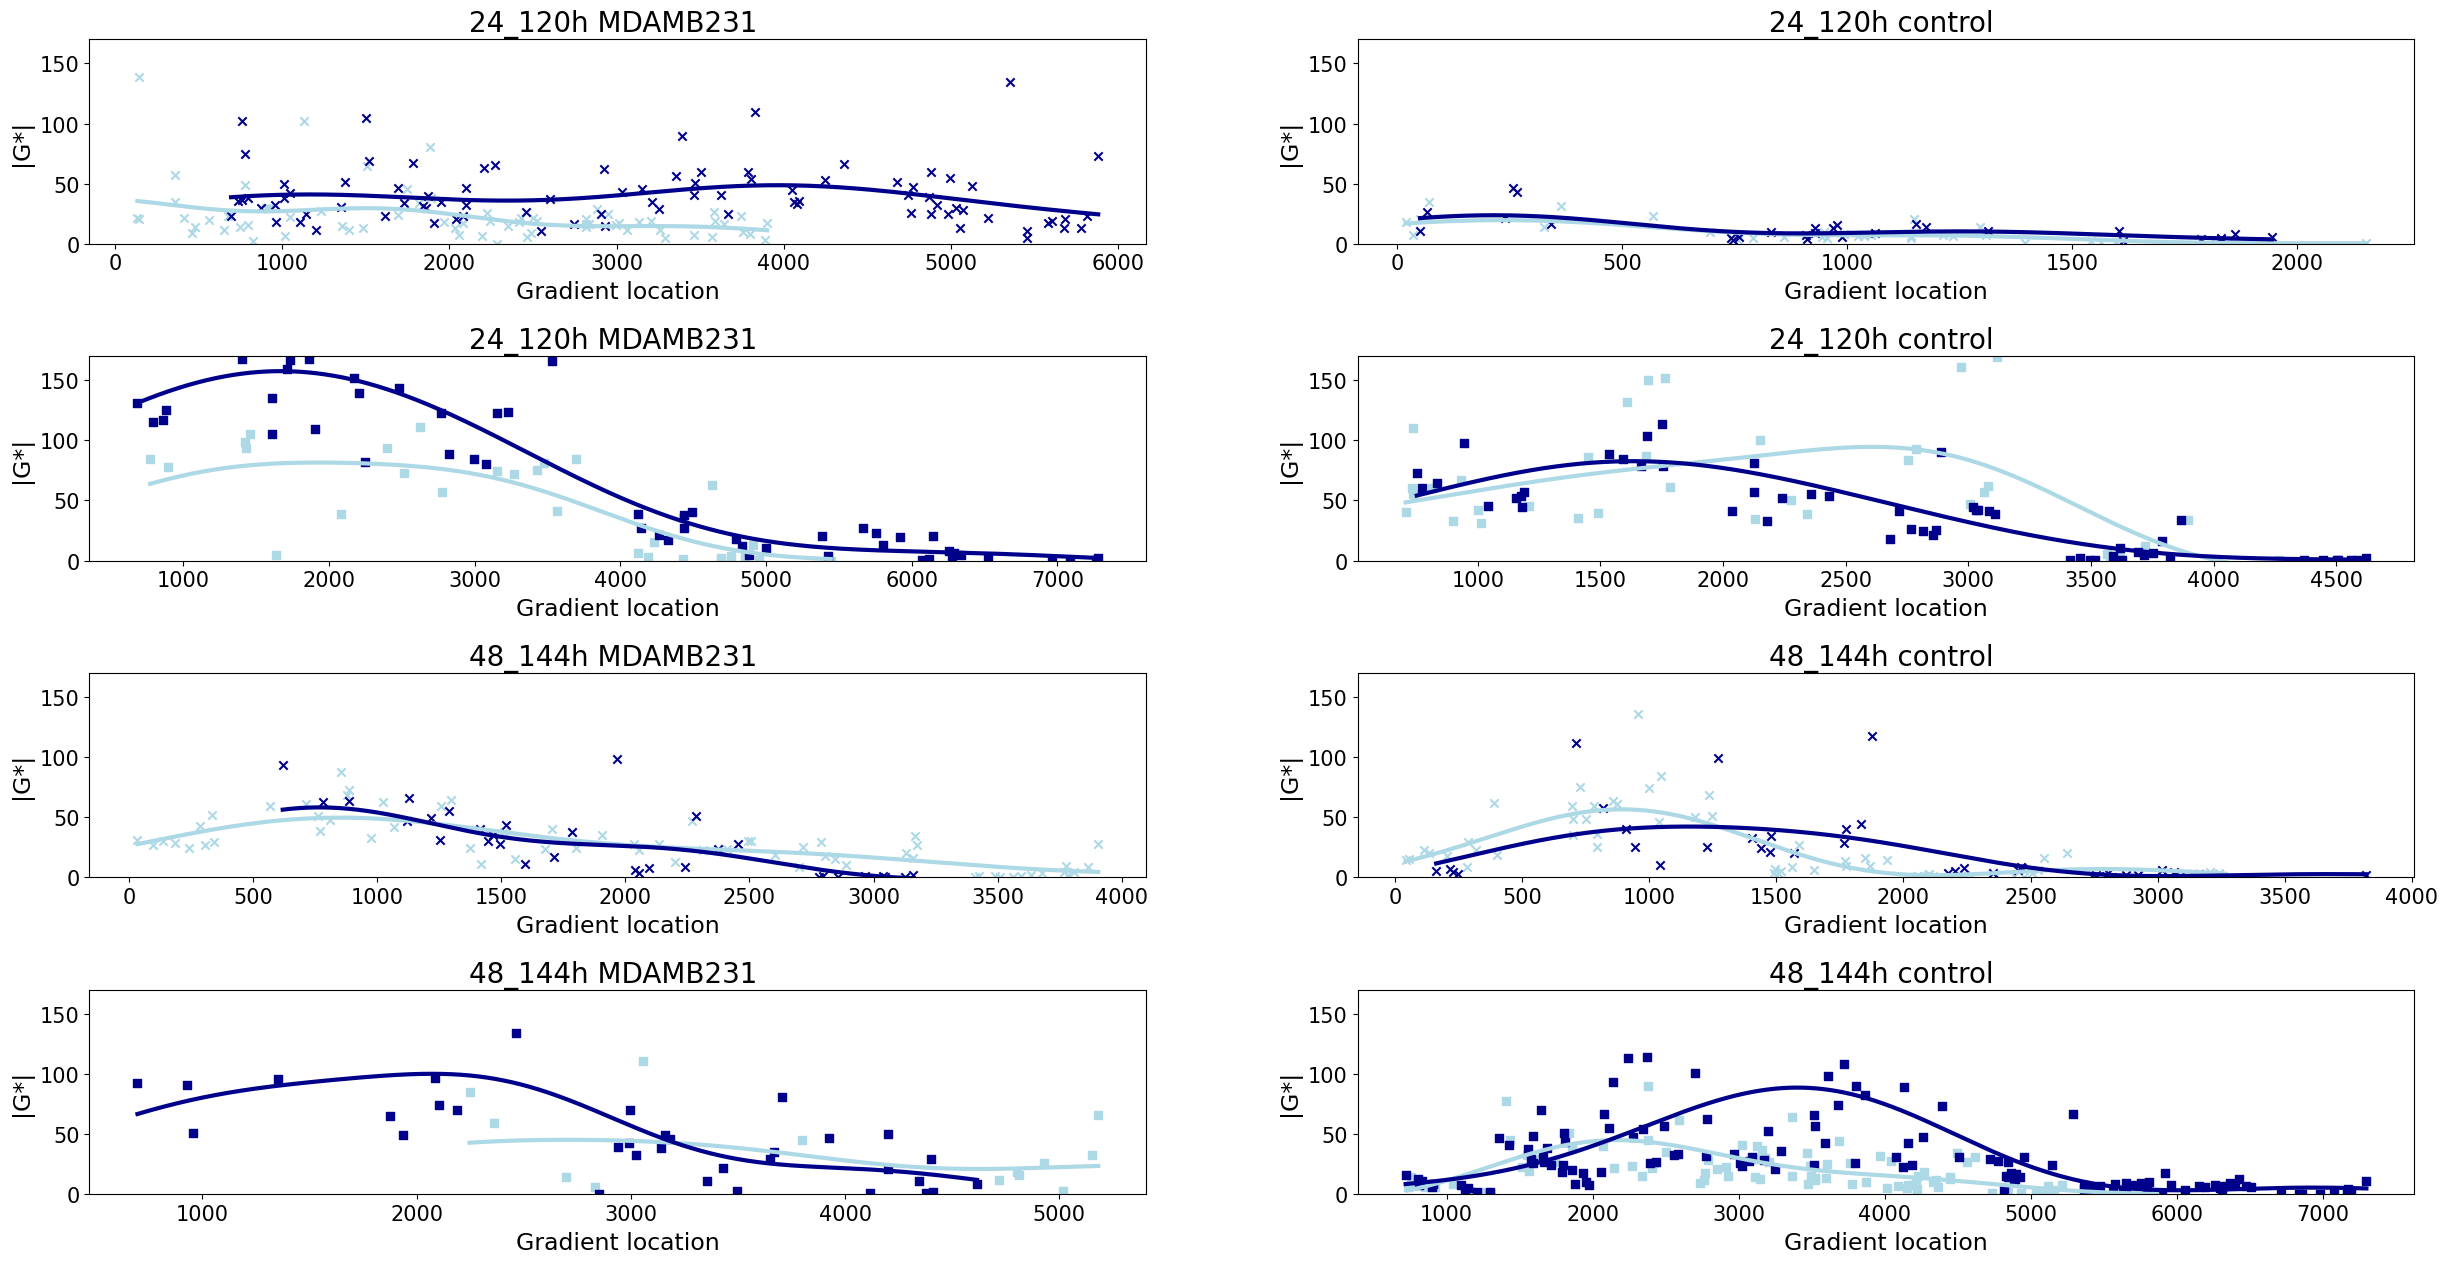

In [107]:
fig, axs = plt.subplots(4, 2, figsize=(30, 15))
plt.subplots_adjust(wspace=0.2, hspace=0.55)
fig.suptitle("", fontsize=18, y=1)

markers=['x','s']

colors = ["lightblue","darkblue"]

for i,j in enumerate(download['incubation_set'].unique()):
    first = download[download['incubation_set']==j]
    
        
    for nn,n in enumerate(first['incubation'].unique()):
        second = first[first['incubation']==n]
        color_type = colors[int(nn)]
        #print(n, color)

        
        for k,l in enumerate(second['experiment'].unique()):
            third = second[second['experiment']==l]
            marker_type = markers[l]
            row = (i*2)+(k)
            #print(l, marker_type)
            
            for m,o in enumerate(third['sample'].unique()):
                column = 0 if o=='MDAMB231' else 1
                fourth = third[third['sample']==o]
                #print(f"set {k}, {n}h, {o}, {str(fourth['day'].unique())},{fourth['gradient_direction'].unique()}")
                date_value = str(fourth['day'].unique()[0])
                ax = axs[row,column]
                #GLS_g(dfffff,ax,color)

                if (fourth['gradient_direction'] == 'stiff_to_soft').all():
                    #ax.scatter(fourth['gradient'],fourth['G_abs'],s=35, c=color, marker = marker_type) #measured from soft to stiff 
                    # filtered_data = fourth[(fourth['gradient'] > 800) & (fourth['gradient'] < 1200)]['G_abs']
                    #fitting(ax,fourth['gradient'],fourth['G_abs'],color_type,marker_type)
                    fitting_kernel(fourth['gradient'],fourth['G_abs'],ax,color_type,marker_type,1)
                    
                else:
                    #fitting(ax,fourth['gradient_inverse'],fourth['G_abs'],color_type, marker_type)
                    fitting_kernel(fourth['gradient_inverse'],fourth['G_abs'],ax,color_type,marker_type,1)
  
                ax.set_xlabel("Gradient location", fontsize= 17,labelpad=5)
                ax.set_ylabel("|G*|", fontsize= 17, labelpad=5)
                ax.set_title(f"{j}h {o} ", fontsize = 20)
                ax.tick_params(axis='both', labelsize=15)
                
                ax.set_ylim (0,170) 
                #ax.set_xlim (0,5000)  
  
                

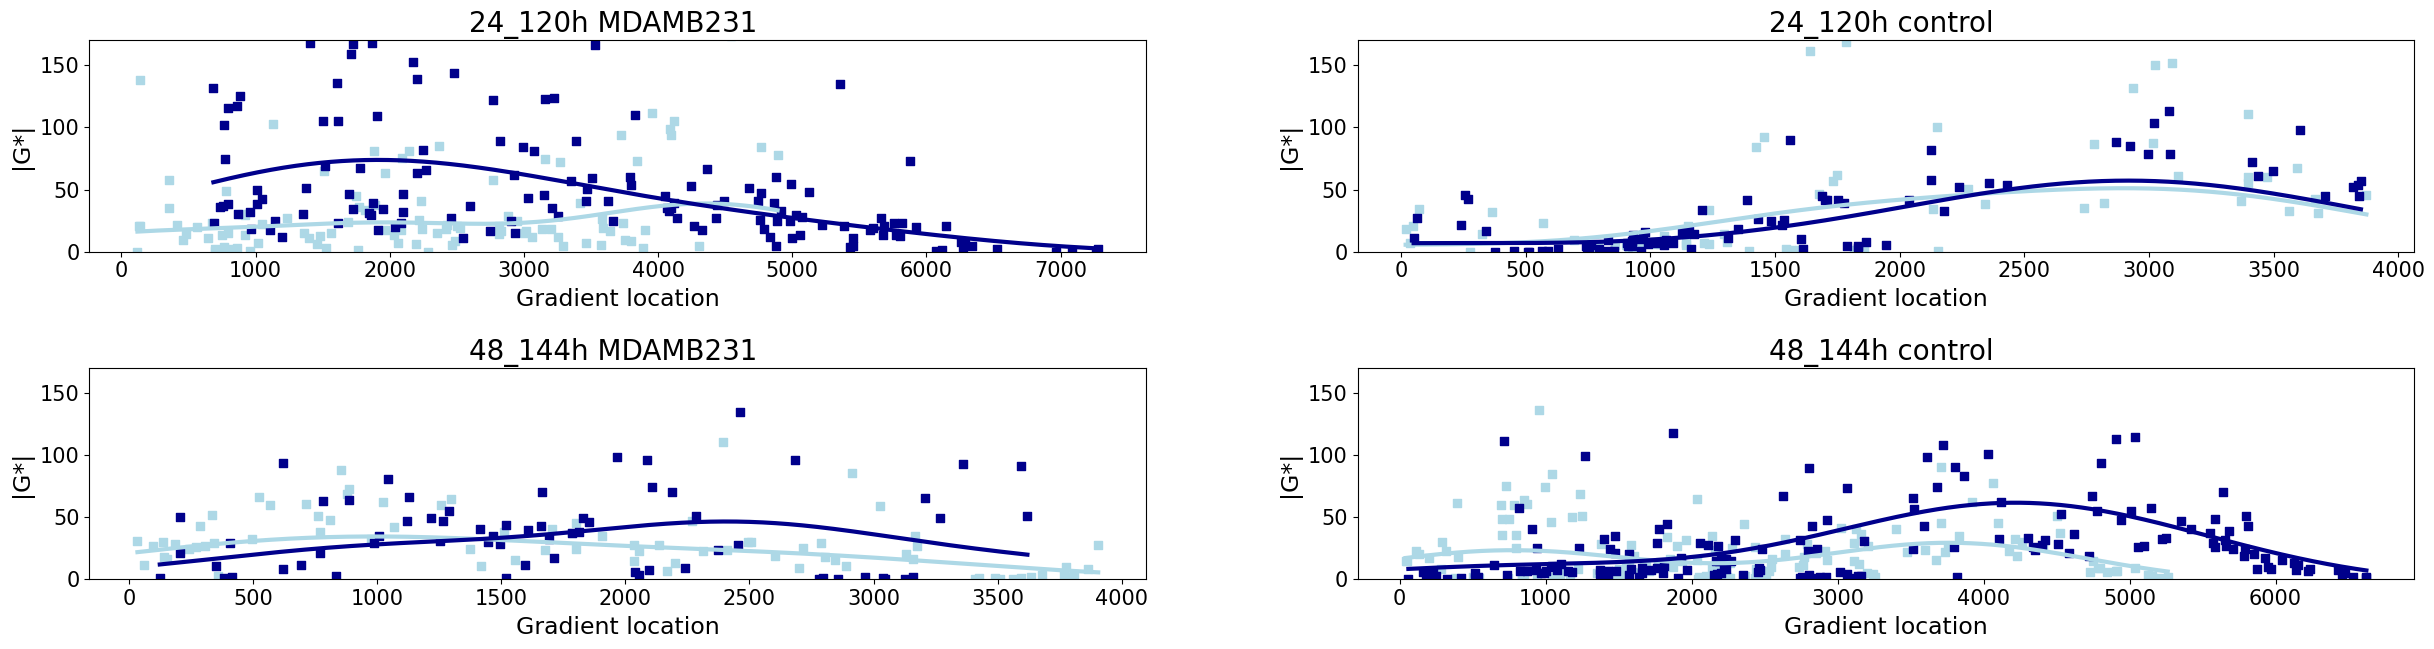

In [104]:
fig, axs = plt.subplots(2, 2, figsize=(30, 7))
plt.subplots_adjust(wspace=0.2, hspace=0.55)
fig.suptitle("", fontsize=18, y=1)

markers=['x','s']

colors = ["lightblue","darkblue"]

for i,j in enumerate(download['incubation_set'].unique()):
    first = download[download['incubation_set']==j]
    row = i
        
    for nn,n in enumerate(first['incubation'].unique()):
        second = first[first['incubation']==n]
        color_type = colors[int(nn)]
        #print(n, color)

        
        # for k,l in enumerate(second['experiment'].unique()):
        #     third = second[second['experiment']==l]
        #     marker_type = markers[l]
        #     row = (i*2)+(k)
        #     #print(l, marker_type)
        
        for m,o in enumerate(second['sample'].unique()):
            column = 0 if o=='MDAMB231' else 1
            fourth = second[second['sample']==o]
            #print(f"set {k}, {n}h, {o}, {str(fourth['day'].unique())},{fourth['gradient_direction'].unique()}")
            date_value = str(fourth['day'].unique()[0])
            ax = axs[row,column]
            #GLS_g(dfffff,ax,color)

            if (fourth['gradient_direction'] == 'stiff_to_soft').all():
                #ax.scatter(fourth['gradient'],fourth['G_abs'],s=35, c=color, marker = marker_type) #measured from soft to stiff 
                # filtered_data = fourth[(fourth['gradient'] > 800) & (fourth['gradient'] < 1200)]['G_abs']
                #fitting(ax,fourth['gradient'],fourth['G_abs'],color_type,marker_type)
                fitting_kernel(fourth['gradient'],fourth['G_abs'],ax,color_type,marker_type,10)
                
            else:
                #fitting(ax,fourth['gradient_inverse'],fourth['G_abs'],color_type, marker_type)
                fitting_kernel(fourth['gradient_inverse'],fourth['G_abs'],ax,color_type,marker_type,10)

            ax.set_xlabel("Gradient location", fontsize= 17,labelpad=5)
            ax.set_ylabel("|G*|", fontsize= 17, labelpad=5)
            ax.set_title(f"{j}h {o} ", fontsize = 20)
            ax.tick_params(axis='both', labelsize=15)
            
            ax.set_ylim (0,170) 
            #ax.set_xlim (0,5000)  
  
                

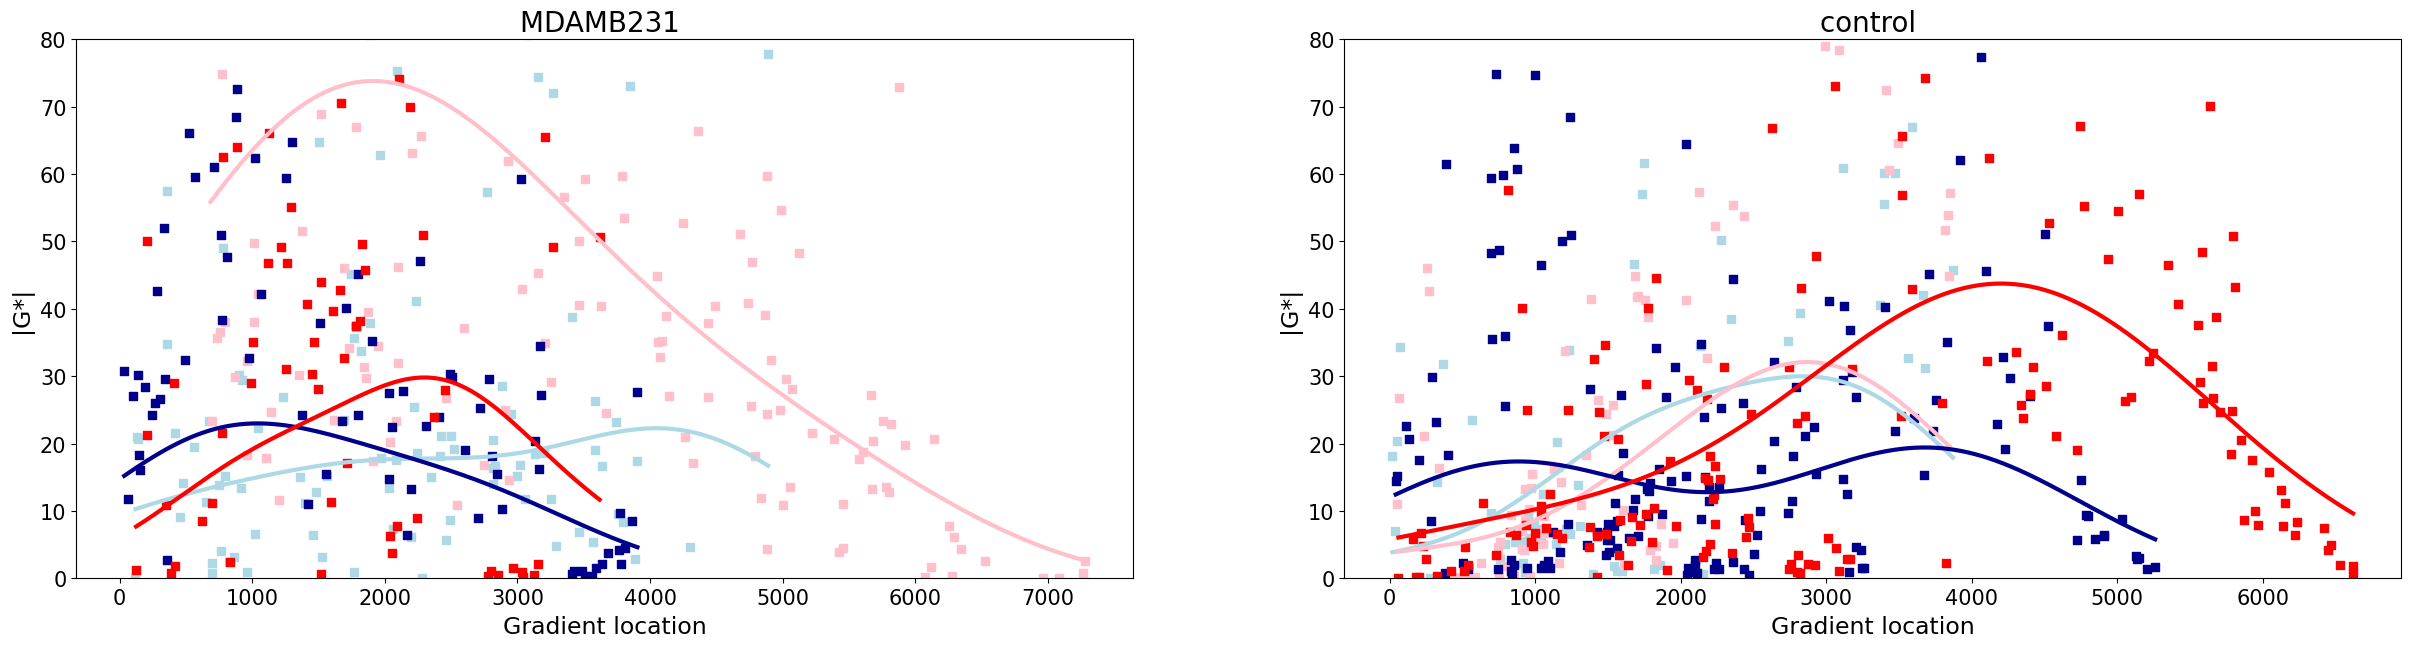

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(30, 7))
plt.subplots_adjust(wspace=0.2, hspace=0.55)
fig.suptitle("", fontsize=18, y=1)

markers=['x','s']

colors = ["lightblue","pink","darkblue","red"]

# for i,j in enumerate(download['incubation_set'].unique()):
#     first = download[download['incubation_set']==j]
#     row = i
        
for nn,n in enumerate(download['incubation'].unique()):
    second = download[download['incubation']==n]
    color_type = colors[int(nn)]
    #print(n, color)

    
    # for k,l in enumerate(second['experiment'].unique()):
    #     third = second[second['experiment']==l]
    #     marker_type = markers[l]
    #     row = (i*2)+(k)
    #     #print(l, marker_type)
    
    for m,o in enumerate(second['sample'].unique()):
        column = 0 if o=='MDAMB231' else 1
        fourth = second[second['sample']==o]
        #print(f"set {k}, {n}h, {o}, {str(fourth['day'].unique())},{fourth['gradient_direction'].unique()}")
        date_value = str(fourth['day'].unique()[0])
        ax = axs[column]
        #GLS_g(dfffff,ax,color)

        if (fourth['gradient_direction'] == 'stiff_to_soft').all():
            #ax.scatter(fourth['gradient'],fourth['G_abs'],s=35, c=color, marker = marker_type) #measured from soft to stiff 
            # filtered_data = fourth[(fourth['gradient'] > 800) & (fourth['gradient'] < 1200)]['G_abs']
            #fitting(ax,fourth['gradient'],fourth['G_abs'],color_type,marker_type)
            fitting_kernel(fourth['gradient'],fourth['G_abs'],ax,color_type,marker_type,10)
            
        else:
            #fitting(ax,fourth['gradient_inverse'],fourth['G_abs'],color_type, marker_type)
            fitting_kernel(fourth['gradient_inverse'],fourth['G_abs'],ax,color_type,marker_type, 30)

        ax.set_xlabel("Gradient location", fontsize= 17,labelpad=5)
        ax.set_ylabel("|G*|", fontsize= 17, labelpad=5)
        ax.set_title(f"{o} ", fontsize = 20)
        ax.tick_params(axis='both', labelsize=15)
        
        ax.set_ylim (0,80) 
        #ax.set_xlim (0,5000)  
  
                

## GLS phase shift

In [28]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

alpha = 0.05

def GLS_phaseshift(data, ax, color):
    # Check for NaNs or infs in input data
    if data['f'].isnull().any() or data['phi_(rad)'].isnull().any():
        print("Data contains NaN values, which might cause issues.")
        return

    if (data['phi_(rad)'] <= 0).any():
        print("Data contains non-positive values in 'phi_(rad)', which will cause issues with log transformation.")
        return

    # Extract x and log-transform y
    x = data['f'].values.reshape(-1, 1)
    y = np.log(data['phi_(rad)'].values)

    # Fit GLS model
    x_const = sm.add_constant(x)
    modelGLS = sm.GLS(y, x_const)
    resultsGSL = modelGLS.fit()

    # Generate predictions
    x_predictedGLS = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    x_predictedGLS_with_const = sm.add_constant(x_predictedGLS)
    y_predictedGLS_log = resultsGSL.predict(x_predictedGLS_with_const)
    y_predictedGLS = np.exp(y_predictedGLS_log)

    # Prediction intervals
    predictions = resultsGSL.get_prediction(x_predictedGLS_with_const)
    pred_summary = predictions.summary_frame(alpha=alpha)
    y_lower_CI = np.exp(pred_summary['obs_ci_lower'])
    y_upper_CI = np.exp(pred_summary['obs_ci_upper'])

    # Plotting
    ax.scatter(data['f'], data['phi_(rad)'], s=4, c=color, label='Data')
    #ax.plot(x_predictedGLS, y_predictedGLS, color=color, label='Fitted Line')
    #ax.fill_between(x_predictedGLS.flatten(), y_lower_CI, y_upper_CI, color=color, alpha=0.1, label='Confidence Interval')
    ax.set_ylim(0, 100)
    ax.set_xlim(0, 5000)
    ax.legend()
    ax.set_xlabel("Frequency (f)")
    ax.set_ylabel("Phase (phi in rad)")

    print("Model fit successfully. Check plot for results.")


set 0, 120h, MDAMB231, ['241111'],['soft_to_stiff']
set 0, 120h, control, ['241111'],['soft_to_stiff']
set 1, 120h, control, ['241125'],['stiff_to_soft']
set 1, 120h, MDAMB231, ['241125'],['stiff_to_soft']

set 0, 24h, control, ['241107'],['soft_to_stiff']
set 0, 24h, MDAMB231, ['241107'],['stiff_to_soft']
set 1, 24h, MDAMB231, ['241121'],['stiff_to_soft']
set 1, 24h, control, ['241121'],['stiff_to_soft']

set 0, 48h, control, ['241108'],['soft_to_stiff']
set 0, 48h, MDAMB231, ['241108'],['soft_to_stiff']
set 1, 48h, MDAMB231, ['241122'],['stiff_to_soft']
set 1, 48h, control, ['241122'],['stiff_to_soft']

set 0, 144h, control, ['241112'],['soft_to_stiff']
set 0, 144h, MDAMB231, ['241112'],['soft_to_stiff']
set 1, 144h, MDAMB231, ['241126'],['stiff_to_soft']
set 1, 144h, control, ['241126'],['stiff_to_soft']



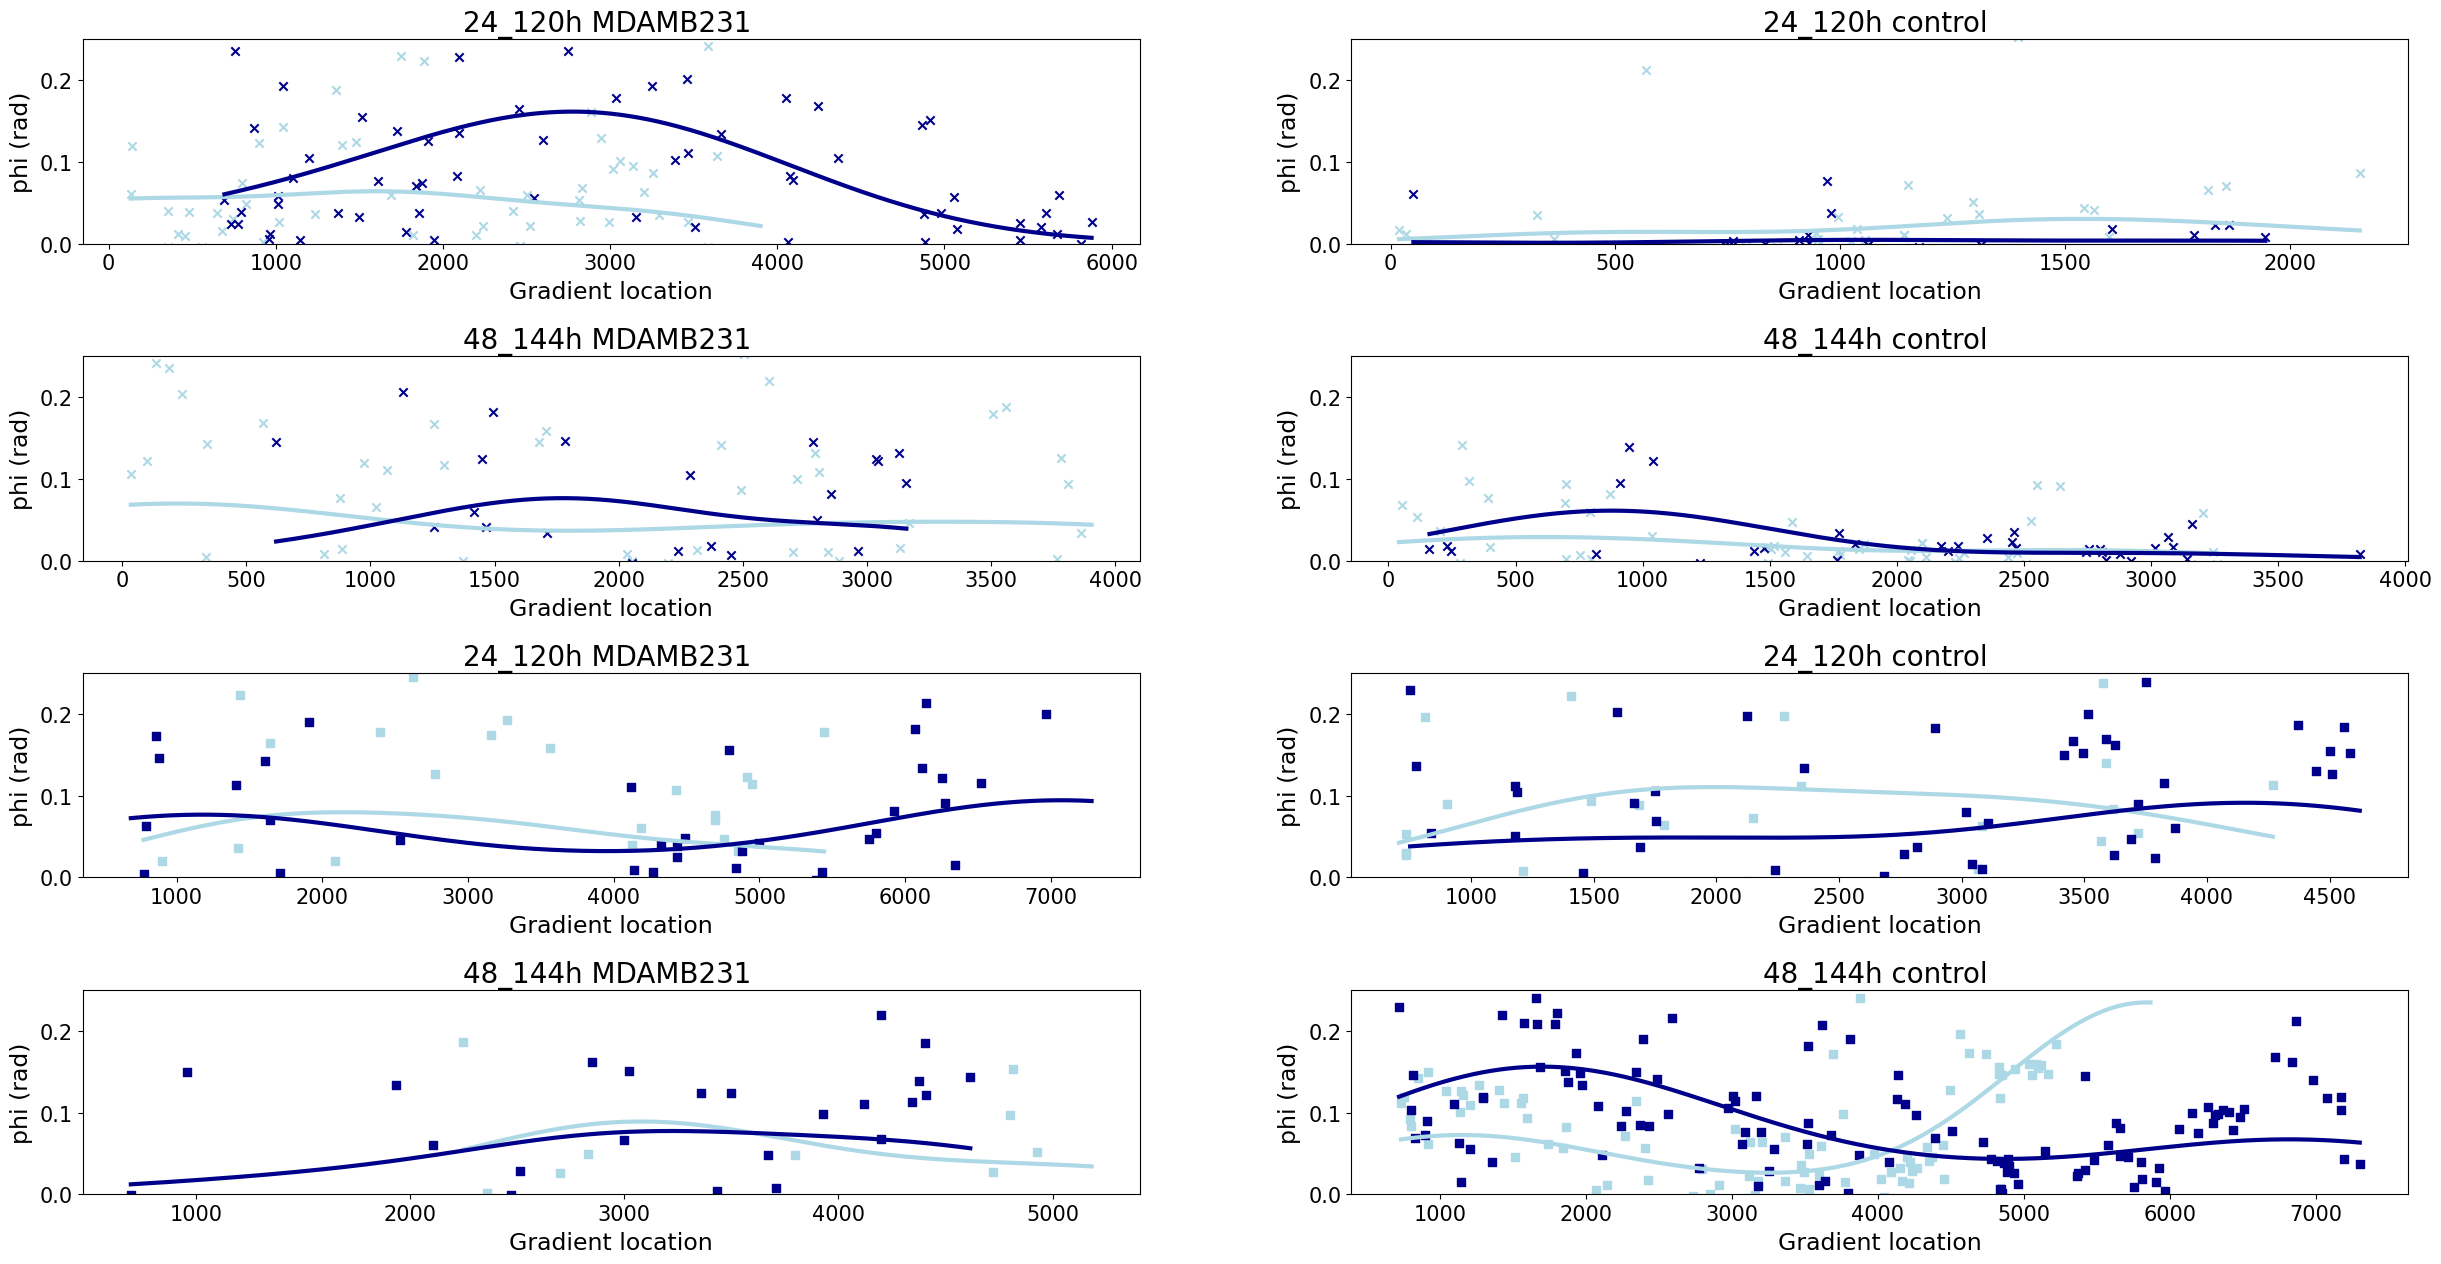

In [90]:
fig, axs = plt.subplots(4, 2, figsize=(30, 15))
plt.subplots_adjust(wspace=0.2, hspace=0.55)
fig.suptitle("", fontsize=18, y=1)

markers=['x','s']

colors = ["lightblue","darkblue"]

for i,j in enumerate(download['incubation_set'].unique()):
    first = download[download['incubation_set']==j]
        
    for nn,n in enumerate(first['incubation'].unique()):
        second = first[first['incubation']==n]
        color_type = colors[int(nn)]
        #print(n, color)

        
        for k,l in enumerate(second['experiment'].unique()):
            third = second[second['experiment']==l]
            marker_type = markers[l]
            row = i+(2*k)
            #print(l, marker_type)
            
            for m,o in enumerate(third['sample'].unique()):
                column = 0 if o=='MDAMB231' else 1
                fourth = third[third['sample']==o]
                print(f"set {k}, {n}h, {o}, {str(fourth['day'].unique())},{fourth['gradient_direction'].unique()}")
                date_value = str(fourth['day'].unique()[0])
                ax = axs[row,column]
                #GLS_g(dfffff,ax,color)
                #print(dfffff)
                
                if (fourth['gradient_direction'] == 'stiff_to_soft').all():
                    #ax.scatter(fourth['gradient'],fourth['G_abs'],s=35, c=color, marker = marker_type) #measured from soft to stiff 
                    # filtered_data = fourth[(fourth['gradient'] > 800) & (fourth['gradient'] < 1200)]['G_abs']
                    #fitting(ax,fourth['gradient'],fourth['G_abs'],color_type,marker_type)
                    fitting_kernel(fourth['gradient'],fourth['phi_(rad)'],ax,color_type,marker_type)
                    
                else:
                    #fitting(ax,fourth['gradient_inverse'],fourth['G_abs'],color_type, marker_type)
                    fitting_kernel(fourth['gradient_inverse'],fourth['phi_(rad)'],ax,color_type,marker_type)
  
                ax.set_xlabel("Gradient location", fontsize= 17,labelpad=5)
                ax.set_ylabel("phi (rad)", fontsize= 17, labelpad=5)
                ax.set_title(f"{j}h {o} ", fontsize = 20)
                ax.tick_params(axis='both', labelsize=15)


                ax.set_ylim (0,0.25) 
                # ax.set_xlim (0,5000)  
                
        print()
                

Text(0.5, 1.0, 'Control sample 24h')

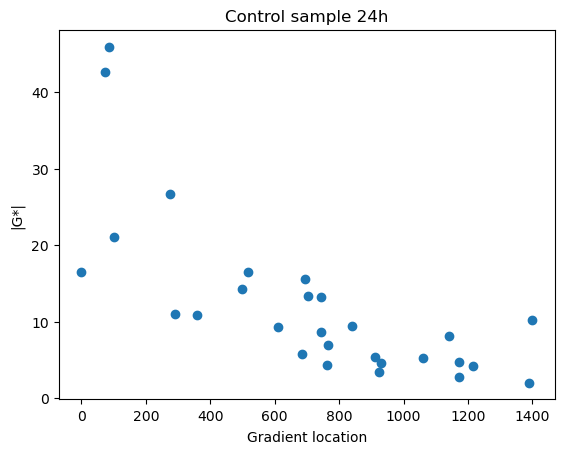

In [9]:
max = control['gradient'].max()
control['x_con'] = max -control['gradient']
control.to_csv('C:/Users/srboval1/OneDrive - Aalto University/Collab/Ivaska_collab/data/241107_24h_control', index=False)

plt.scatter(control['x_con'],control['G_abs'])
plt.xlabel("Gradient location", fontsize= 10,labelpad=5)
plt.ylabel("|G*|", fontsize= 10, labelpad=5)
plt.title('Control sample 24h')